---
<h1 style="text-align: center;">
CSCI 4521: Applied Machine Learning (Fall 2024)
</h1>

<h1 style="text-align: center;">
Homework 6
</h1>

<h3 style="text-align: center;">
(Due Tue, Dec. 10, 11:59 PM CT)
</h3>

---

![mnist.png](attachment:a66dea12-a8dc-4cd9-b987-36f0ffe55f5d.png)

Image from https://en.wikipedia.org/wiki/MNIST_database

### **Problem 1. (75 points)** In this problem, your task is to build and train a convolutional neural network (CNN) to classify hand-written digits. We will use the MNIST dataset where each data point is an image of a hand-written digit and its label indicates the value of the digit written ($0, 1, \dots, 9$). Use the provided code (in `hw6_utils.py`) to load and normalize the data in this homework (you do not need to do any other preprocessing). Your CNN must have the following architecture:
- #### Input: 1-channel input image of size 28x28 pixels
- #### Convolution layer: Convolution kernel of size (3, 3) with a stride of 1, dilation of size 1, and bias. Number of input channels: 1; Number of output channels: 20; Do not use any padding
- #### ReLU activation function
- #### Max pool: 2x2 kernel size with stride of 2
- #### Dropout layer with probability $p=0.50$
- #### Flatten input for fully-connected layers
- #### Fully-connected layer 1. Input is flattened output from conv layer with bias; Number of output nodes: 128
- #### ReLU activation function
- #### Dropout layer with probability $p=0.50$
- #### Fully-connected layer 2: Number of input nodes: 128 and bias; Number of output nodes: 10
- #### Softmax activation function on output layer (note, you do not need to specify this anywhere, it is included when using cross entropy loss `torch.nn.CrossEntropyLoss()`.

### Train your CNN for $N$ epochs (you must decide $N$) on all the training data using vanilla SGD (e.g., `torch.optim.SGD()`) as the optimizer with mini batches of size 32 images and cross entropy loss (e.g., `torch.nn.CrossEntropyLoss()`). In each epoch, print out the cumulative training loss, training error rate, cumulative test loss, and test error rate. Once training has converged (you must decide when this happens), apply your learned model to the test set one last time and print out the cumulative test loss and test error rate. Also, randomly select 5 images which your model incorrectly predicted and plot the images. What is the correct label and what is the label your network predicted for each of the 5 images? Why do you think your model misclassified these images?

### You must use **PyTorch** to build and train your neural network, no other packages will be accepted (for example, you cannot use Tensorflow). If you use anything other than PyTorch to build your network, you will receive no credit for this homework.

### Write your code and display your figures here

In [93]:
# Numpy Imports
import numpy as np
np.random.seed(5782267)

# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize

# Miscellaneous imports
from six.moves import urllib
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [94]:
# Helper functions from the given file.
def load_MNIST(batch_size: int, normalize_vals: tuple[float, float]) -> tuple:

    # for correctly download the dataset using torchvision, do not change!

    opener = urllib.request.build_opener()
    opener.addheaders = [('User-agent', 'Mozilla/5.0')]
    urllib.request.install_opener(opener)

    norm1_val, norm2_val = normalize_vals

    transforms = Compose([ToTensor(), Normalize((norm1_val,), (norm2_val,))])


    train_dataset = torchvision.datasets.MNIST(root='MNIST-data',
                                               train=True,
                                               download=True,
                                               transform=transforms)

    test_dataset = torchvision.datasets.MNIST(root='MNIST-data',
                                              train=False,
                                              transform=transforms)


    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               shuffle=False)


    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False)

    return train_dataset, test_dataset, train_loader, test_loader


def convert_data_to_numpy(dataset) -> tuple[np.ndarray, np.ndarray]:
    X = []
    y = []
    for i in range(len(dataset)):
        X.append(dataset[i][0][0].flatten().numpy())# flatten it to 1d vector
        y.append(dataset[i][1])

    X = np.array(X)
    y = np.array(y)

    return X, y

# for plotting the low-dimensional points from PCA in Question 2
def plot_points(points_x: list[float], points_y: list[float], labels: list[int], filename: str) -> None:

    points_x = np.array(points_x)
    points_y = np.array(points_y)
    group = np.array(labels)
    cdict = {0: 'tab:blue',
             1: 'tab:orange',
             2: 'tab:green',
             3: 'tab:red',
             4: 'tab:purple',
             5: 'tab:brown',
             6: 'tab:pink',
             7: 'tab:gray',
             8: 'tab:olive',
             9: 'tab:cyan'}

    fig, ax = plt.subplots()
    for g in np.unique(group):
        ix = np.where(group == g)
        ax.scatter(points_x[ix], points_y[ix], c = cdict[g], label = g, s = 10)
    ax.legend()

    plt.savefig(filename)

In [95]:
# Given values
batch_size = 32
normalize_vals = (0.1307, 0.3081)

# load MNIST dataset
train_dataset, test_dataset, train_loader, test_loader = load_MNIST(batch_size, normalize_vals)

In [96]:
# Build the CNN structure
class build_cnn_model(nn.Module):
  def __init__(self):
    super().__init__()
    # Using architecture specified in the assignment description
    self.conv1= nn.Conv2d(1,20,kernel_size=3,stride=1,dilation=1,bias=True)
    self.relu1= nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.dropout1 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(20*13*13, 128, bias=True)
    self.relu2= nn.ReLU()
    self.dropout2 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(128, 10, bias=True)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.pool1(x)
    x = self.dropout1(x)
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = self.relu2(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x


In [97]:
# Train and evaluate the model
def train_and_evaluate(model, train_loader, test_loader, num_epochs, device):
  # Defin functions to calculate entropy loss, and initalise the optimiser and model
  entropy_loss= nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  model = model.to(device)

  # For all epochs
  for epoch in range(num_epochs):
    # Train the model
    model.train()
    training_loss_per_epoch= 0
    correct_predictions= 0
    total_trained_instances= 0

    # For each data-pair in the training set
    for image, label in train_loader:
      # Get the image ad label
      image =  image.to(device)
      label = label.to(device)
      optimizer.zero_grad()

      # Predict using model
      predict= model(image)
      # Find loss
      loss= entropy_loss(predict, label)
      loss.backward()
      optimizer.step()
      # Add it to total loss
      training_loss_per_epoch += loss.item()
      #Get predicted value
      _, predicted = torch.max(predict, 1)
      total_trained_instances += label.size(0)
      correct_predictions += (predicted == label).sum().item()

    # calculate error rate
    train_error_rate = 1 - (correct_predictions / total_trained_instances)
    # test the model using the test set
    model.eval()
    test_loss = 0
    correct_test= 0
    total_test=0

    with torch.no_grad():
      # for each image label pair in the test data, repeat the same process as the training data
      for image, label in test_loader:
          image, label = image.to(device), label.to(device)
          predict = model(image)
          loss = entropy_loss(predict, label)

          test_loss += loss.item()
          _, predicted = torch.max(predict, 1)
          total_test += label.size(0)
          correct_test += (predicted == label).sum().item()

    test_error_rate = 1 - (correct_test / total_test)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {training_loss_per_epoch:.4f}, Train Error Rate: {train_error_rate:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Error Rate: {test_error_rate:.4f}")

  # Final evaluation
  print("\n------Final Test Evaluation")
  print(f"Test Loss: {test_loss:.4f}, Test Error Rate: {test_error_rate:.4f}")

  return model

In [98]:
# Plot misclassified images
def plot_incorrect_images(model, test_loader, device):
  # evalate the model
  model.eval()
  incorrect = []

  with torch.no_grad():
    # for each image in the test data if the incorrect image was predicted select it
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)

      for img, pred, true in zip(images, predicted, labels):
        if pred != true:
            incorrect.append((img.cpu().numpy(), true.item(), pred.item()))
        if len(incorrect) == 5:
            break
      if len(incorrect) == 5:
        break

  # Plot wrongly identified images
  fig, axes = plt.subplots(1, 5, figsize=(10, 5))
  for i, (img, true_label, pred_label) in enumerate(incorrect):
    # This thing is so annoying, you get all kinds of errors without this configuration
    # Essentially the image needs to show and the colors need to work for the data
    axes[i].imshow(img.squeeze(), cmap="gray")
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label}")
    axes[i].axis("off")
  plt.tight_layout()
  plt.show()

Epoch 1/10
Train Loss: 650.9137, Train Error Rate: 0.1073
Test Loss: 28.0198, Test Error Rate: 0.0278
Epoch 2/10
Train Loss: 349.5802, Train Error Rate: 0.0583
Test Loss: 23.0579, Test Error Rate: 0.0226
Epoch 3/10
Train Loss: 292.9754, Train Error Rate: 0.0468
Test Loss: 17.5202, Test Error Rate: 0.0178
Epoch 4/10
Train Loss: 253.5526, Train Error Rate: 0.0414
Test Loss: 16.1929, Test Error Rate: 0.0164
Epoch 5/10
Train Loss: 229.4957, Train Error Rate: 0.0373
Test Loss: 15.1106, Test Error Rate: 0.0156
Epoch 6/10
Train Loss: 217.0924, Train Error Rate: 0.0354
Test Loss: 16.4111, Test Error Rate: 0.0166
Epoch 7/10
Train Loss: 206.4287, Train Error Rate: 0.0333
Test Loss: 13.9300, Test Error Rate: 0.0145
Epoch 8/10
Train Loss: 196.9506, Train Error Rate: 0.0308
Test Loss: 13.6041, Test Error Rate: 0.0139
Epoch 9/10
Train Loss: 191.7729, Train Error Rate: 0.0312
Test Loss: 14.0075, Test Error Rate: 0.0141
Epoch 10/10
Train Loss: 181.3975, Train Error Rate: 0.0296
Test Loss: 12.9463, Tes

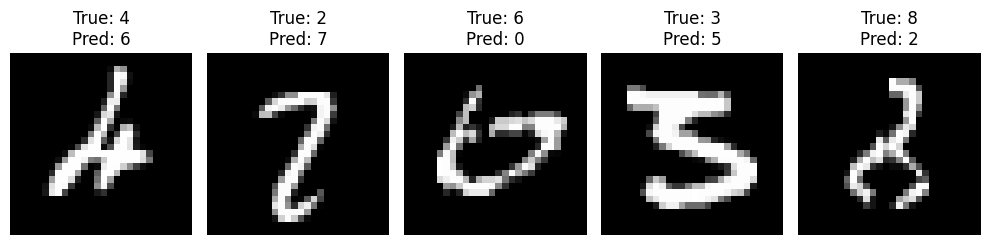

In [99]:
# Given
batch_size = 32
normalize_vals = (0.1307, 0.3081)
train_dataset, test_dataset, train_loader, test_loader = load_MNIST(batch_size, normalize_vals)

# Instantiate the model, train, and evaluate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_cnn_model()
# The error rate essentially stops decreasing significantly after this point
num_epochs = 10
trained_model = train_and_evaluate(model, train_loader, test_loader, num_epochs, device)

# Plot misclassified images
plot_incorrect_images(trained_model, test_loader, device)

### Answer the text questions here

Q. What is the correct label and what is the label your network predicted for each of the 5 images?
A. the correct labels and the predictions are visible on the image provided above.

Q. Why do you think your model misclassified these images?
A. I think there are several reaosns. For one, google colab limits the number of epochs I can run (I topped out at 13, but the error rate stopped decreasing significantly after 10), and so I could probably improve perfromance with more epochs.
Additionally there are intrinsic similarities in the pictures and the predictions and I can see why the model might mistake these. For example, in one iteration the 2 had a very small "base" making it look like a 7 with a small error at the bottom. Since the model aggregates infromation, it would look like more 7's that it was trained on, then 2's.

---


### **Problem 2. (25 points)** In this problem, your task is to apply principal component analysis (PCA) to the MNIST dataset to reduce the dimensionality of each image from 784 to 2 and visualize the images in the lower-dimensional subspace. Apply PCA to all the training data to learn the projection vector. Then, project each image in the training dataset to $\mathbb{R}^2$. Use the provided plotting function `plot_points()` (in `hw6_utils.py`) to plot each projected image as a point in a 2-dimensional figure where the x-axis is principal component 1 and the y-axis is principal component 2. Color each point in the figure according to the label of each image so we can visualize how well PCA reduced the dimensionality according to how closely the images are grouped by label. (Note, only use the labels to visualize how well PCA did, do not use the labels anywhere else.) What are your observations from the figure? Where did PCA reduce the dimensionality well and where did it not do well? Note, you may get some complex numbers when computing the eigenvalues and eigenvectors. You can use `np.real()` to only keep the real part.


### Write your code and display your figures here

In [100]:
# Setup system
np.random.seed(5782267)
normalize_vals = (0.1307, 0.3081)
batch_size = 100

# load MNIST dataset
train_dataset, test_dataset, train_loader, test_loader = load_MNIST(batch_size, normalize_vals)

# convert to numpy
X, y = convert_data_to_numpy(train_dataset)

PCA projection complete. Saved visualization to 'mnist_pca_projection.png'.


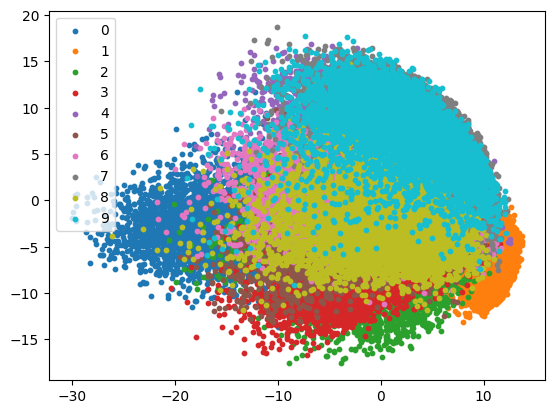

In [101]:
# Standardize data
X = X - np.mean(X, axis=0)

# Compute the covariance matrix
cov_matrix = np.cov(X, rowvar=False)

# Select the top 2 real eigenvectors of the covariance matrix
eigvals, eigvects = np.linalg.eig(cov_matrix)
eigvals= np.real(eigvals)
eigvects= np.real(eigvects)
index= np.argsort(eigvals)[::-1]
eigvals = eigvals[index]
eigvects = eigvects[:, index]
top_2_eigvects = eigvects[:, :2]

# Map data onto the 2 eigenvectors we calculated
X = np.dot(X, top_2_eigvects)
# Split data into x and y axes for graphing
projected_x = X[:, 0]
projected_y = X[:, 1]

# Plot answer
plot_points(projected_x, projected_y, y, "mnist_pca_projection.png")

print("PCA projection complete. Saved visualization to 'mnist_pca_projection.png'.")


### Answer the text questions here

Q. What are your observations from the figure?
A. The PCA actually looks a lttle messier than I thought it would. There are boundaries of grey and brown in specific that look minimal enough to be consumed by other groupings which must mean there are interesting properties that can be learned about these features in larger dmensions. Specifically however:


1.   9, 0, 1 and 2 seem well differentiated
2.   6, 3 and 7 seem to have a lot of overlap specifically with (0,8), 7 and 9 respectively. This makes some degree of sense because of structural similarities in the nubers. FOr example, a 6 with a high connection point for the loop looks similar to a 0, and one with too curved of a top loop looks very similar to 8.



 Q. Where did PCA reduce the dimensionality well and where did it not do well?
 A. The PCA did well clustering 0, and not so well clustering 1,4,7,9. 1 and 7 in particular are not so well grouped, potentiall because they are both essentially the same lines, drawn at slight different angles to a varying length.

---

## Extra Credit Problems

### In order for extra credit solutions to be considered, you must provide reasonable solutions to all parts of Problems 1 and 2 above. If you skip any part of a problem or do not provide a reasonable solution, we will not count any extra credit towards your grade.

---

### **Extra Credit 1. (3 points)** Describe how to split the data to train a machine learning model (e.g., SVM). Make sure to describe two ways, one using cross validation and another without using cross validation. Explain why we split the data in these ways and what can happen if the data is split incorrectly.

### Answer the questions here

1. One way to split data when using SVMs is to split it into a straight train-test split without considering cross validation.
2. This can in some specific ratio as per your needs, but typical splits include 80-20 or 70-30.
3. The main reason to split data is to ensure our model is making prediction on data it has never seen before. We dont want the model to overfit to any specific dataset, instead wanting it to be generalist.
4. If the split is imbalanced in some way, for example if we pick a set of data with all values in some column between 1-20, when in fact the wider dataset has a trend of ranging from anywhere between 1 and 70, we will liekly never see higher predictions. That is to say if we are not random enough we can misrepresent the data.

1. Another way to split data is to include a component of cross validation.
2. In this case we segment the data into groups or "folds". Over all possible i iterations we select the ith fold to use as test data, and use the rest for training.
3. Then, since we have i results for the i choices, we use some strategy to select the best representative like average or median.
4. The reason we make this split is one to avoid bias more systematically by accounting for more possible unseen points, and also because our estimate is now better for any general dataset without increasing our dataset size which can be industrially expensive.
5. Issues that can occur were we to split the data incorrectly include an obvious increase in runtime and real costs, and also data leakage, because if we process the data before splitting it, we may inadvertantently discover the testing sets feature from infromation that should have stayed confidential from train set.

---

### **Extra Credit 2. (10 points)** In this problem, your task is to segment an image using $k$-means. We can use $k$-means to cluster pixels with similar (color) values together to generate a segmented or compressed version of the original image. Apply $k$-means to the provided image `umn_csci.png`. For each $k=\{3,5,7\}$, generate a segmented image and compute the cumulative loss (i.e., distortion measure from the lecture notes). (Note, it may be helpful to test on a smaller version of the image `umn_csci.png` to ensure your code works but report final results on the full version.)

### Write your code and display your figures here

In [102]:
# Looked at popular libraries for image loading and also resizing found this using perplexity
# https://scikit-image.org/docs/stable/api/skimage.html
from skimage.io import imread
from skimage.transform import resize

# Colab imports
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
# Read the image
img = imread('/content/drive/MyDrive/colab_data/umn_csci.png')

# test_img = resize(img, (img.shape[0] // 4, img.shape[1] // 4), anti_aliasing=True)

In [104]:
# Normalise
img = img / 255.0

# Because the image is RGBA
flattened_img = img.reshape(-1, img.shape[-1])

In [105]:
def make_image_segments(flattened_img, k_groups=10):
  # Do the clustering
  kmeans = KMeans(n_clusters=k_groups, random_state=5782267).fit(flattened_img)
  labels = kmeans.labels_
  centers = kmeans.cluster_centers_
  distortion = kmeans.inertia_
  segments = centers[labels]
  segments = segments.reshape(img.shape)
  return segments, distortion

for k in [3, 5, 7]:
  seg, dis = make_image_segments(flattened_img, k)
  print(f"k={k}, distortion={dis}")

k=3, distortion=10017.112756137
k=5, distortion=4282.372945822203
k=7, distortion=2318.3383138276085


---

### For all problems, make sure to write and submit clean, working code. Reminder, you cannot use ChatGPT or similar technologies. Please see the syllabus for more details.